# Lab 5: Lexical Semantics

Given the following (lemma, category) pairs:

```
(’the’,’DT’), (’man’,’NN’), (’swim’,’VB’), (’with’, ’PR’), (’a’, ’DT’),
(’girl’,’NN’), (’and’, ’CC’), (’a’, ’DT’), (’boy’, ’NN’), (’whilst’, ’PR’),
(’the’, ’DT’), (’woman’, ’NN’), (’walk’, ’VB’)
```
- For each pair, when possible, print their most frequent WordNet synset

- For each pair of words, when possible, print their corresponding least common subsumer (LCS) and their similarity value, using the following functions:

    - Path Similarity

    - Leacock-Chodorow Similarity

    - Wu-Palmer Similarity

    - Lin Similarity

Normalize similarity values when necessary. What similarity seems better?

## Import Libraries

In [5]:
import nltk
from nltk.corpus import wordnet as wn
from nltk.corpus import wordnet_ic

nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('wordnet_ic')

brown_ic = wordnet_ic.ic('ic-brown.dat')

from itertools import product
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\xavier\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\xavier\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet_ic to
[nltk_data]     C:\Users\xavier\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet_ic is already up-to-date!


## Distance Analysis

First of all, let's recall how each of the distances are calculated. It's important to find boundaries for them so that it's possible to make some transforms in order to take them to the 
$[0, 1]$ interval so  that all of them are comparable.

**Shortest Path Length**: 
$$
Sim(s1,s2) = \dfrac{1}{SPL(s1,s2)}
$$

where SPL(s1,s2) is the Shortest Path Length from s1 to s2 as vertex-countings (similarity of a word and itself is 1) so that 

$$
0 < Sim(s1,s2) \leq 1
$$

**Leacock & Chodorow**: 

$$
Sim(s1,s2) = −\log{\dfrac{SPL(s1,s2)}{2·MaxDepth}}
$$

where depth(s) = SPL(TopSynset,s) and $MaxDepth = \max_{s\in WN}depth(s)$

It is possible to show that there's a maximum value for the similarity of two synsets, which is $\log{2·MaxDepth}$

$$
Sim(s1,s2) = −\log{\dfrac{SPL(s1,s2)}{2·MaxDepth}} = -\log{SPL(s1,s2)} + \log{(2MaxDepth)} \leq \log(2MaxDepth)
$$

so that

$$
0 < \dfrac{Sim(s1,s2)}{\log\left(2MaxDepth\right)} \leq 1
$$


In [6]:
max_depth = max(max(len(hyp_path) for hyp_path in ss.hypernym_paths()) for ss in wn.all_synsets())
norm_value = np.log(2 * max_depth)

print(f"The max depth is {max_depth} and the normalization value is {norm_value}")

The max depth is 20 and the normalization value is 3.6888794541139363


**Wu & Palmer**:

$$
Sim(s1,s2) = \dfrac{2*depth(LCS(s1,s2))}{depth_{LCS(s1,s2)}(s1)+depth_{LCS(s1,s2)}(s2)}
$$

where LCS(s1,s2) = Lowest Common Subsumer of s1 and s2 and $depth_{s'}(s) = SPL(TopSynset,s)$ through s'

so the highest similarity would be when $depth_{LCS(s1,s2)}(s1)=depth_{LCS(s1,s2)}(s2)$, which is when s1 and s2 are siblings and $depth(LCS(s1,s2)) = maxDepth$. So the maximum value for the similarity of two synsets is 1.


**Lin**: 

$$
Sim(s1,s2) = \dfrac{2*IC(LCS(s1,s2))}{IC(s1)+IC(s2)}
$$

where $IC(s) = −log_2(P(s))$ = information content of s (from frequencies in a corpus)

In the case of Lin, the maximum value for the similarity of two synsets is 1 (when $IC(s1)=IC(s2)$ and $IC(LCS(s1,s2)) = IC(s1) = IC(s2)$)

# Most Frequent Wordnet Synset

The provided sample needs to be processed so that the POS tags are in the necessary format for Wordnet synsets getter.

In [7]:
# Preprocess the pairs and discard the ones that do not have a POS tag
ls_pairs = [('the','DT'), ('man','NN'), ('swim','VB'), ('with', 'PR'), ('a', 'DT'),
            ('girl','NN'), ('and', 'CC'), ('a', 'DT'), ('boy', 'NN'), ('whilst', 'PR'),
            ('the', 'DT'), ('woman', 'NN'), ('walk', 'VB')]

d_wn_pos = {'NN': wn.NOUN, 'VB': wn.VERB, 'JJ': wn.ADJ, 'RB': wn.ADV}
ls_pairs_wn = [(pair[0], d_wn_pos.get(pair[1])) for pair in ls_pairs if pair[1] in d_wn_pos]
ls_pairs_wn

[('man', 'n'),
 ('swim', 'v'),
 ('girl', 'n'),
 ('boy', 'n'),
 ('woman', 'n'),
 ('walk', 'v')]

After the sample is processed, the closest synset for each of them is calculated. Given Wordnet lexical structure, this means the first synset in the list obtained after calling `wordnet.synsets`.

In [8]:
def get_synsets(ls_pairs_wn):
    '''
    Calculate the closest synset for each word in the list of pairs
    '''
    d_synsets = {}
    for pair in ls_pairs_wn:
        synsets = wn.synsets(pair[0], pair[1])
        if synsets:
            d_synsets[pair[0]] = synsets[0]
        else:
            d_synsets[pair[0]] = None
    return d_synsets

d_synsets = get_synsets(ls_pairs_wn)
d_synsets

{'man': Synset('man.n.01'),
 'swim': Synset('swim.v.01'),
 'girl': Synset('girl.n.01'),
 'boy': Synset('male_child.n.01'),
 'woman': Synset('woman.n.01'),
 'walk': Synset('walk.v.01')}

# Get LCS

The Lowest Common Subsummer (LCS) of a given pair of synsets is the first common parent of both synsets.

In [9]:
def get_lcs(syn1, syn2):
    '''
    Get the lowest common subsummer between two synsets
    '''
    return syn1.lowest_common_hypernyms(syn2)

def get_all_lcs(ls_pairs_wn):
    '''
    Input: list of pairs of words with their POS tag
    output: dictionary with the pairs as keys and the lowest common synset as values
    '''
    ls_pairs_comb = [c for c in list(product(ls_pairs_wn, ls_pairs_wn)) if len(c) == 2 and c[0] != c[1]]
    ls_d_pairs_comb = [get_synsets(comb) for comb in ls_pairs_comb]
    d_lcs = {tuple(d.values()): get_lcs(*list(d.values())) for d in ls_d_pairs_comb}
    return d_lcs

d_lcs_ = get_all_lcs(ls_pairs_wn)
# print(d_lcs_.values())
df = pd.DataFrame(d_lcs_.values(), index=d_lcs_.keys(), columns=['lcs']).reset_index()
df.rename(columns={'level_0': 'word1', 'level_1':'word2'}, inplace=True)
df

,word1,word2,lcs
0,Synset('man.n.01'),Synset('swim.v.01'),None
1,Synset('man.n.01'),Synset('girl.n.01'),Synset('adult.n.01')
2,Synset('man.n.01'),Synset('male_child.n.01'),Synset('male.n.02')
3,Synset('man.n.01'),Synset('woman.n.01'),Synset('adult.n.01')
4,Synset('man.n.01'),Synset('walk.v.01'),None
5,Synset('swim.v.01'),Synset('man.n.01'),None
6,Synset('swim.v.01'),Synset('girl.n.01'),None
7,Synset('swim.v.01'),Synset('male_child.n.01'),None
8,Synset('swim.v.01'),Synset('woman.n.01'),None
9,Synset('swim.v.01'),Synset('walk.v.01'),Synset('travel.v.01')


In [10]:
"""df_words = df.copy()
df_words['word1'] = df_words['word1'].apply(lambda synset: synset.name())
df_words['word2'] = df_words['word2'].apply(lambda synset: synset.name())

# Now, 'df_with_names' contains synset names in the 'word1' column
df_words


pa = df.pivot(index='word1', columns='word2', values='lcs')
fig, ax = plt.subplots(1, 4, figsize = (30, 8))
_ = fig.suptitle('Word Similarities of Nouns')
_ = sns.heatmap(pa, ax = ax[0], center=0.5, annot=True, cmap = 'RdYlGn', vmin = 0, vmax = 1).set(title = 'Path Similarity')"""

"df_words = df.copy()\ndf_words['word1'] = df_words['word1'].apply(lambda synset: synset.name())\ndf_words['word2'] = df_words['word2'].apply(lambda synset: synset.name())\n\n# Now, 'df_with_names' contains synset names in the 'word1' column\ndf_words\n\n\npa = df.pivot(index='word1', columns='word2', values='lcs')\nfig, ax = plt.subplots(1, 4, figsize = (30, 8))\n_ = fig.suptitle('Word Similarities of Nouns')\n_ = sns.heatmap(pa, ax = ax[0], center=0.5, annot=True, cmap = 'RdYlGn', vmin = 0, vmax = 1).set(title = 'Path Similarity')"

Now, the not normalized similarity values are calculated for each of the pairs of synsets. The similarity values are calculated using the four different methods described above.

In [11]:
def get_path_similarity(syn1, syn2):
    return syn1.path_similarity(syn2)

def get_lch_similarity(syn1, syn2):
    try:
        return syn1.lch_similarity(syn2)
    except:
        return None
    
def get_wup_similarity(syn1, syn2):
    try:
        return syn1.wup_similarity(syn2)
    except:
        return None
    
def get_lin_similarity(syn1, syn2):
    try:
        return syn1.lin_similarity(syn2, brown_ic)
    except:
        return None
    
df['path_sim'] = df.apply(lambda x: x['word1'].path_similarity(x['word2']), axis=1)
df['lch_sim'] = df.apply(lambda x: get_lch_similarity(x['word1'], x['word2']), axis=1)
df['wup_sim'] = df.apply(lambda x: get_wup_similarity(x['word1'], x['word2']), axis=1)
df['lin_sim'] = df.apply(lambda x: get_lin_similarity(x['word1'], x['word2']), axis=1)

df.sort_values(by='lcs', ascending=False)

,word1,word2,lcs,path_sim,lch_sim,wup_sim,lin_sim
13,Synset('girl.n.01'),Synset('woman.n.01'),Synset('woman.n.01'),0.500000,2.944439,0.631579,0.906780
22,Synset('woman.n.01'),Synset('girl.n.01'),Synset('woman.n.01'),0.500000,2.944439,0.947368,0.906780
9,Synset('swim.v.01'),Synset('walk.v.01'),Synset('travel.v.01'),0.333333,2.159484,0.333333,0.491005
26,Synset('walk.v.01'),Synset('swim.v.01'),Synset('travel.v.01'),0.333333,2.159484,0.333333,0.491005
12,Synset('girl.n.01'),Synset('male_child.n.01'),Synset('person.n.01'),0.166667,1.845827,0.631579,0.292728
17,Synset('male_child.n.01'),Synset('girl.n.01'),Synset('person.n.01'),0.166667,1.845827,0.631579,0.292728
18,Synset('male_child.n.01'),Synset('woman.n.01'),Synset('person.n.01'),0.200000,2.028148,0.666667,0.318423
23,Synset('woman.n.01'),Synset('male_child.n.01'),Synset('person.n.01'),0.200000,2.028148,0.666667,0.318423
2,Synset('man.n.01'),Synset('male_child.n.01'),Synset('male.n.02'),0.333333,2.538974,0.666667,0.729472
15,Synset('male_child.n.01'),Synset('man.n.01'),Synset('male.n.02'),0.333333,2.538974,0.666667,0.729472


As mentioned at the begining of this work, not all the similarities are between 0 and 1. This is why the values of Leacock and Chodorow simmilarity are normalized so that they are comparable.

In [12]:
norm_value = np.log(2 * max_depth)

df_norm = df.copy()
df_norm['lch_sim'] = df_norm['lch_sim'] / norm_value
df_norm = df_norm.loc[:, df.columns]
df_norm = df_norm.sort_values(by='lcs', ascending=False)
df_norm

,word1,word2,lcs,path_sim,lch_sim,wup_sim,lin_sim
13,Synset('girl.n.01'),Synset('woman.n.01'),Synset('woman.n.01'),0.500000,0.798193,0.631579,0.906780
22,Synset('woman.n.01'),Synset('girl.n.01'),Synset('woman.n.01'),0.500000,0.798193,0.947368,0.906780
9,Synset('swim.v.01'),Synset('walk.v.01'),Synset('travel.v.01'),0.333333,0.585404,0.333333,0.491005
26,Synset('walk.v.01'),Synset('swim.v.01'),Synset('travel.v.01'),0.333333,0.585404,0.333333,0.491005
12,Synset('girl.n.01'),Synset('male_child.n.01'),Synset('person.n.01'),0.166667,0.500376,0.631579,0.292728
17,Synset('male_child.n.01'),Synset('girl.n.01'),Synset('person.n.01'),0.166667,0.500376,0.631579,0.292728
18,Synset('male_child.n.01'),Synset('woman.n.01'),Synset('person.n.01'),0.200000,0.549801,0.666667,0.318423
23,Synset('woman.n.01'),Synset('male_child.n.01'),Synset('person.n.01'),0.200000,0.549801,0.666667,0.318423
2,Synset('man.n.01'),Synset('male_child.n.01'),Synset('male.n.02'),0.333333,0.688278,0.666667,0.729472
15,Synset('male_child.n.01'),Synset('man.n.01'),Synset('male.n.02'),0.333333,0.688278,0.666667,0.729472


As it can be observed from the table above, most of the LCS are missing. This is because the synsets are not related in the Wordnet hierarchy, i.e., verbs and nouns don't have any common parent in the ontology.

This is why, also, most of the similarity measures couldn't be computed. However, some of them introduce a ghost node common for all the hierarchies so that some sort of value can be computed. This  is the case of the Path Similarity and the Wu Palmer.

In addition to this, it is remarkable that Wu Palmer is not always symmetric. This is because the depth of the LCS is calculated from the first synset to the second one. This is why the similarity values are not always the same.

The Wu-Palmer similarity measure is not symmetric due to the way it is calculated and the nature of the information used to measure semantic similarity between two words. The Wu-Palmer similarity is based on the idea that two words are more similar if they share a common ancestor in the hierarchy of concepts in a semantic network, such as WordNet, a lexical database that organizes words into a hierarchical structure.

The asymmetry arises from how the Least Common Subsumer (LCS) is chosen. The LCS is the closest common ancestor to both words in the hierarchy. Since the closest common ancestor depends on the relative position of the words in the hierarchy, the result can be different when the words $w_1$ and $w_2$ are swapped. Therefore, the Wu-Palmer similarity is not symmetric because $\text{sim}(w_1, w_2)$ is not necessarily equal to $\text{sim}(w_2, w_1)$.

In summary, the asymmetry in the Wu-Palmer similarity measure is due to the dependence on the relative position of words in the hierarchy and how the closest common ancestor is selected to calculate semantic similarity.

In [13]:
# Example of the asymetric behavior
df_norm.iloc[:2, :]

,word1,word2,lcs,path_sim,lch_sim,wup_sim,lin_sim
13,Synset('girl.n.01'),Synset('woman.n.01'),Synset('woman.n.01'),0.5,0.798193,0.631579,0.90678
22,Synset('woman.n.01'),Synset('girl.n.01'),Synset('woman.n.01'),0.5,0.798193,0.947368,0.90678


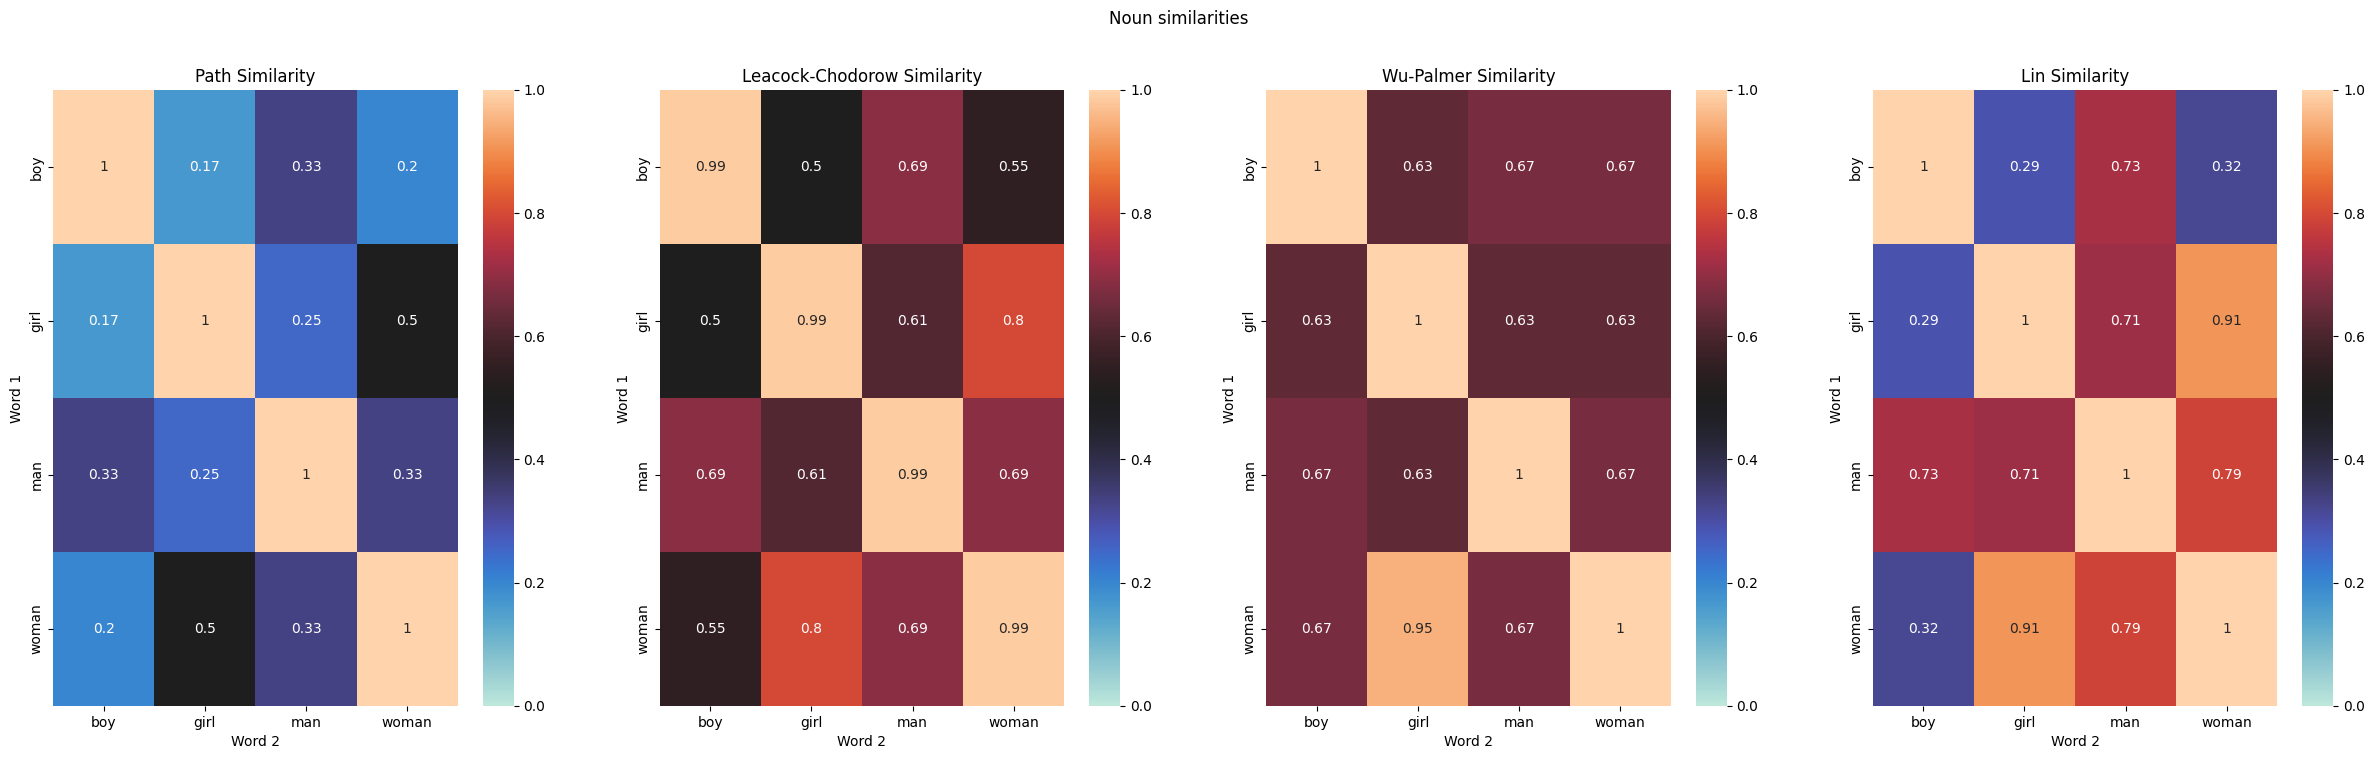

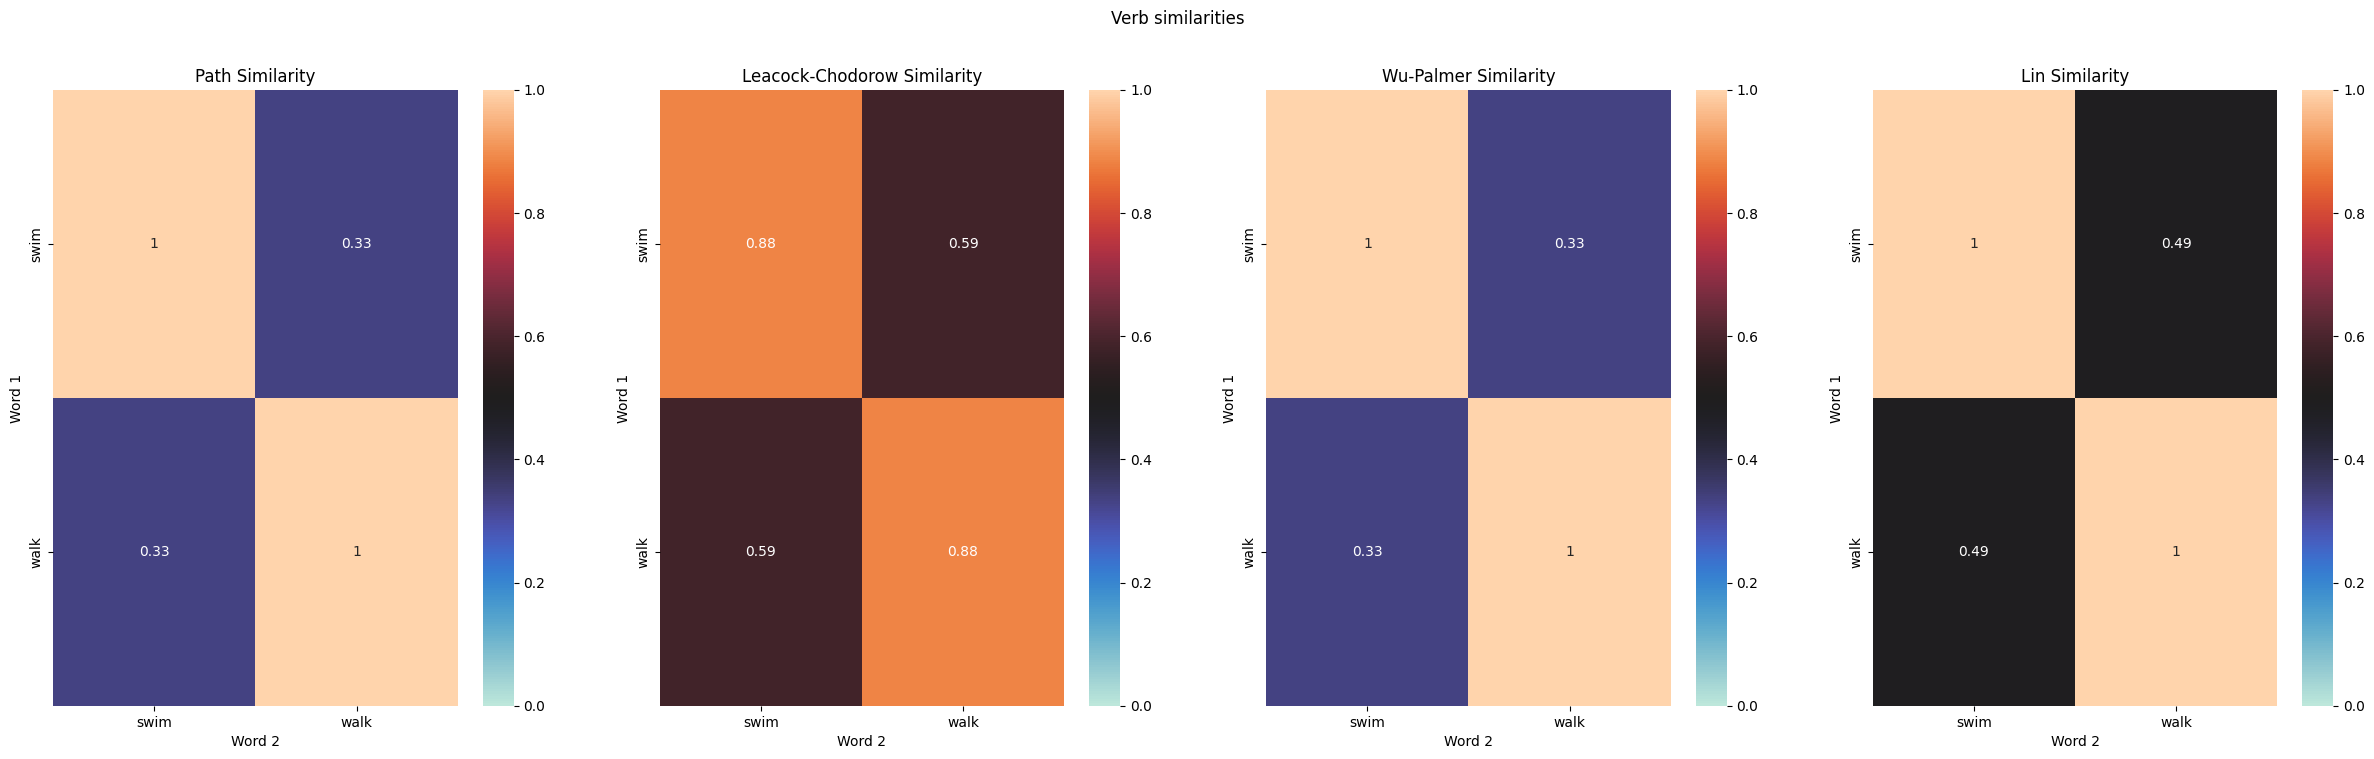

In [33]:
def get_pair_mc_synset(ls_pairs):
   """Returns the most common synset for each pair (word, POS) in the list of pairs"""
   mc_synsets = []
   for pair in ls_pairs:
      tag = d_wn_pos.get(pair[1])
      if tag:
         mc_synsets.append((pair, (wn.synsets(pair[0], tag))))
   return mc_synsets

mc_synset = get_pair_mc_synset(ls_pairs)

nouns_sim, verbs_sim = list(), list()

for syn1, syn2 in product(mc_synset, mc_synset):
  w1, w2 = syn1[1][0], syn2[1][0] # Get the first synset of each pair
  pos1, pos2 = syn1[0][1], syn2[0][1] # Get the POS tag of each word
  if pos1 == pos2:
    if pos1 == 'NN':
      nouns_sim.append([syn1[0][0], syn2[0][0], get_path_similarity(w1, w2), get_lch_similarity(w1, w2), get_wup_similarity(w1, w2), get_lin_similarity(w1, w2)])
    elif pos1 == 'VB':
      verbs_sim.append([syn1[0][0], syn2[0][0], get_path_similarity(w1, w2), get_lch_similarity(w1, w2), get_wup_similarity(w1, w2), get_lin_similarity(w1, w2)])

df = pd.DataFrame(nouns_sim, columns = ['Word 1', 'Word 2', 'Path', 'LC', 'WP', 'Lin'])
df['LC'] = df['LC'] / norm_value
df = df.loc[:, df.columns]

# Noun similarities
pa_nouns = df.pivot(index='Word 1', columns='Word 2', values='Path')
lc_nouns = df.pivot(index='Word 1', columns='Word 2', values='LC')
wp_nouns = df.pivot(index='Word 1', columns='Word 2', values='WP')
lin_nouns = df.pivot(index='Word 1', columns='Word 2', values='Lin')

fig, ax = plt.subplots(1, 4, figsize=(30, 8))
_ = fig.suptitle('Noun similarities')
_ = sns.heatmap(pa_nouns, ax=ax[0], center=0.5, annot=True, vmin=0, vmax=1).set(title='Path Similarity')
_ = sns.heatmap(lc_nouns, ax=ax[1], center=0.5, annot=True, vmin=0, vmax=1).set(title='Leacock-Chodorow Similarity')
_ = sns.heatmap(wp_nouns, ax=ax[2], center=0.5, annot=True, vmin=0, vmax=1).set(title='Wu-Palmer Similarity')
_ = sns.heatmap(lin_nouns, ax=ax[3], center=0.5, annot=True, vmin=0, vmax=1).set(title='Lin Similarity')

df = pd.DataFrame(verbs_sim, columns = ['Word 1', 'Word 2', 'Path', 'LC', 'WP', 'Lin'])
df['LC'] = df['LC'] / norm_value
df = df.loc[:, df.columns]

# Verb similarities
pa_verbs = df.pivot(index='Word 1', columns='Word 2', values='Path')
lc_verbs = df.pivot(index='Word 1', columns='Word 2', values='LC')
wp_verbs = df.pivot(index='Word 1', columns='Word 2', values='WP')
lin_verbs = df.pivot(index='Word 1', columns='Word 2', values='Lin')

fig, ax = plt.subplots(1, 4, figsize=(30, 8))
_ = fig.suptitle('Verb similarities')
_ = sns.heatmap(pa_verbs, ax=ax[0], center=0.5, annot=True, vmin=0, vmax=1).set(title='Path Similarity')
_ = sns.heatmap(lc_verbs, ax=ax[1], center=0.5, annot=True, vmin=0, vmax=1).set(title='Leacock-Chodorow Similarity')
_ = sns.heatmap(wp_verbs, ax=ax[2], center=0.5, annot=True, vmin=0, vmax=1).set(title='Wu-Palmer Similarity')
_ = sns.heatmap(lin_verbs, ax=ax[3], center=0.5, annot=True, vmin=0, vmax=1).set(title='Lin Similarity')

plt.show()


# Conclusions

The use of synsets proportions a way to take into account the semantic meaning of the words. In this work, four different measures have been calculated.

Each of them has its advantages and disadvantages.

1. **Path Similarity:**
   - **Advantages:**
     - Simple and easy to understand.
     - It provides a straightforward measure of similarity based on the length of the shortest path between two concepts in the hierarchical structure.
   - **Disadvantages:**
     - Ignores the depth of the hierarchy, so it may not give accurate results when dealing with very shallow or very deep hierarchies.
     - Fails to capture the nuances of word relationships beyond the number of edges in the hierarchy.

2. **Leacock-Chodorow Similarity:**
   - **Advantages:**
     - It takes into account the depth of the hierarchy by using a logarithmic function.
     - Provides a more refined similarity measure than simple Path Similarity.
   - **Disadvantages:**
     - Still relatively simple and may not capture all aspects of word similarity, especially when dealing with highly specific or general terms.
     - The logarithmic function might not be ideal for all applications and may require tuning.

3. **Wu-Palmer Similarity:**
   - **Advantages:**
     - Considers the depth of the least common subsumer (LCS) in the hierarchy, providing a more refined measure of similarity.
     - Tends to produce better results than Path Similarity and Leacock-Chodorow in various applications.
   - **Disadvantages:**
     - Not symmetric, meaning that $(\text{sim}(w_1, w_2))$ is not necessarily equal to $(\text{sim}(w_2, w_1))$.
     - May not work well when dealing with highly specific terms with deep hierarchies.

4. **Lin Similarity:**
   - **Advantages:**
     - Takes into account not only the depth of the hierarchy but also the information content of the terms.
     - Often produces more accurate similarity scores than the previous measures.
   - **Disadvantages:**
     - Requires additional information content, which can be challenging to estimate accurately.
     - May be computationally more expensive than the simpler measures.

In summary, each of these similarity measures has its own strengths and weaknesses. The choice of which one to use depends on the specific application, the characteristics of the data, and the availability of additional resources (such as information content estimates). Researchers and practitioners often experiment with different measures to determine which one works best for their particular use case.

This is why, it makes sense to consider that, in case of having the statistical information needed, Lin Similarity looks the most accurate and trustworthy. Otherwise, Leacock-Chodorow and Wu-Palmer are good candidates. However, the lack of symmetry of the latter make Leacock-Chodorow the most sensible choice.